## Python Notebook: Intro to PCA and Clustering, Part 1: Two ENSO Indices

This notebook was written by Mathew Barlow (Mathew_Barlow@uml.edu), Professor of Climate Science, Department of Environmental, Earth, and Atmospheric Sciences, University of Massachusetts Lowell. The is Version 1, 14 March 2023.

The notebook is intended to provide a basic introduction to Principal Component Analysis (PCA) and k-means clustering through application of the techniques to the joint variability of two standard El Nino - Southern Oscillation (ENSO) indices, Nino3.4 and the SOI. Principal Components are also referred to as Empirical Orthogonal Functiions (EOFs), so the analysis is also relevant to EOFs, although the terminology varies slightly. This example is too simple to give a good sense of the power of these methods or some of the important subtleties in their use, but is simple enough to more clearly show some of their basic aspects.

The data for the indices needs to be available in two text files, nino34.txt and soi.txt, in the same directory as the notebook. The data was obtained from NOAA's Physical Sciences Laboratory (PSL) at https://psl.noaa.gov/data/climateindices/list/. More information about the indices can be found at that link.

For a discussion of both techniques, please see, for example, Wilks, 2011: Stastical Methods in Atmospheric Sciences, 3rd Edition. Academic Press.

### 1. Set up

First, import the packages we need and set up inline plotting

In [1]:
# import the packages we need for basic calculations and plotting
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import sklearn.cluster
import sklearn.metrics 
import pandas as pd

# set up inline plotting
%matplotlib inline


### 2. Read in the data

Make a function to read in the Nino3.4 and SOI data from the PSL text files. (This requires that the files be in the same directory as the notebook, although it could be modified to specify the full path to access the files from another location.)

In [34]:
# define function to read in a PSL formatted text file
# from https://psl.noaa.gov/data/climateindices/list/
# returns the start year, end year, and values of the index

def read_psl(filename):
    file_in = open(filename, 'r')

    line = file_in.readline()
    start_year = int(line.strip().split()[0])
    end_year = int(line.strip().split()[1])

    nyr = end_year - start_year + 1
    index = np.zeros(nyr*12)

    for iyr in range(start_year, end_year+1):
        line = file_in.readline()
        values = np.array((line.strip().split()[1::])).astype(float)
        index[12*(iyr-start_year):12*(iyr-start_year)+12] = values

    index[index==-99.99] = np.nan
    
    print('start year: '+str(start_year)+', end year: '+str(end_year))
    
    return(start_year, end_year, index)

Use the function to read in both indices

In [3]:
# use our function to read in SOI and Nino3.4 data
(start_year, end_year, soi) = read_psl('soi.txt')
(start_year, end_year, nino34) = read_psl('nino34.txt')

start year: 1948, end year: 2022
start year: 1948, end year: 2022


Since we have the start year and end year and we know the data is monthly, we can also make a list of the dates, which is useful for plotting. For simplicity, we are keeping the data in numpy arrays here but a good next step would be to put all the data into a pandas dataframe.

In [35]:
# make a list of the times for the data
times = pd.date_range(start=str(start_year)+'-01', end=str(end_year)+'-12', freq='MS')

### 3. Look at the basic relationship between the two indices

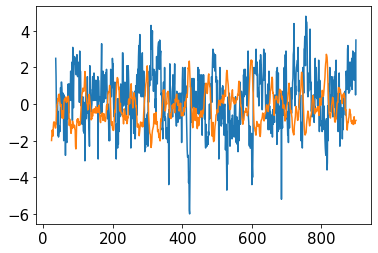

In [36]:
# make a simple plot of both indices
plt.plot(soi)
plt.plot(nino34)
# don't need the following command in a notebook, but it supresses text output we don't need
plt.show()

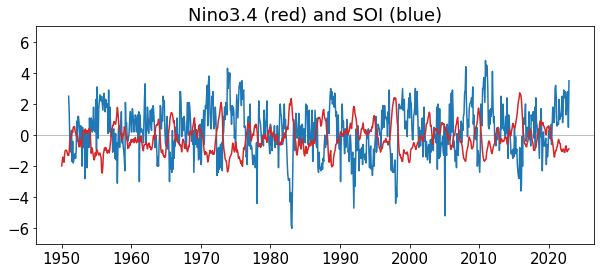

In [37]:
# make a slightly nicer plot
fig=plt.figure(figsize=(10, 4))
plt.rcParams["font.size"] = "15"
plt.axhline(y = 0, linewidth=0.5, color='gray')
plt.plot(times, soi, color='tab:blue', linewidth=1.5)
plt.plot(times, nino34, color='tab:red', linewidth=1.5)
plt.ylim(-7,7)
plt.title('Nino3.4 (red) and SOI (blue)')
plt.show()

The data look related, as we would expect from two ENSO indices. A good check on relationships is always a scatter plot.

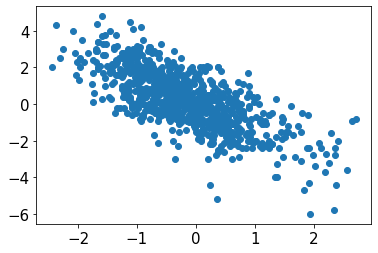

In [38]:
# simple scatter plot
plt.scatter(nino34, soi)
plt.show()

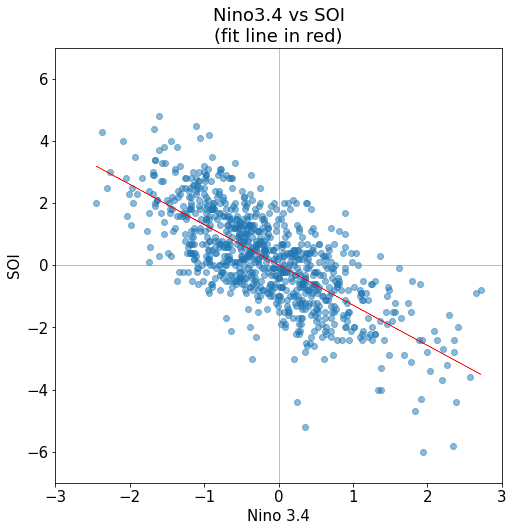

In [39]:
# nicer scatter plot
fig=plt.figure(figsize=(8, 8))
plt.rcParams["font.size"] = "15"

plt.ylim(-7, 7)
plt.xlim(-3, 3)
plt.scatter(nino34, soi, alpha=0.5)
plt.axvline(x=0, c="gray", linewidth=0.5)
plt.axhline(y=0, c="gray", linewidth=0.5)
plt.xlabel('Nino 3.4')
plt.ylabel('SOI')

# add regression / fit line, ignoring NaNs
idx = np.isfinite(nino34) & np.isfinite(soi)
x = nino34[idx]
y = soi[idx]
fit = np.poly1d(np.polyfit(x, y, 1))
plt.plot(x, fit(x), color='red', linewidth=0.5)

plt.title('Nino3.4 vs SOI\n(fit line in red)')

plt.show()
         
# calculate r2 for polyfit
# https://stackoverflow.com/questions/58986593/np-poly1d-how-to-calculate-r2

Looks like a strong, fairly linear relationship. Let's calculate the correlation.

In [40]:
# define a function to calculate Pearson correlation,
# accounting for the possibility of NaNs (undefined values)

def pcorr(a, b):
    idx = np.isfinite(a) & np.isfinite(b)
    x = a[idx]
    xmean = np.mean(x)
    y = b[idx]
    ymean = np.mean(y)
    covar = np.mean((x-xmean)*(y-ymean))
    xstd = np.sqrt(np.mean((x-xmean)*(x-xmean)))
    ystd = np.sqrt(np.mean((y-ymean)*(y-ymean)))
    corr = covar/(xstd*ystd)
    return(corr)

print('correlation:',round(pcorr(nino34, soi), 4))

correlation: -0.7182


### 4. Principal Component Analysis

First, we prepare our data by removing the mean (which isn't considered in PCA) and by dividing the two indices by their respective standard deviations, so that they are comparable in magnitude (not necessary, but ensures that both are weighted equally in the analysis). We also need to remove any undefined values.

The normalized Nino3.4 index will be *x1*, the normalized SOI index will be *x2*, and the combined array of both will be *X*.

In [42]:
# index of defined values
idx = np.isfinite(nino34) & np.isfinite(soi)

x1 = nino34[idx]
x1 = x1-np.mean(x1)
x1_std = np.sqrt(np.mean(x1*x1))
x1 = x1/x1_std

x2 = soi[idx]
x2 = x2-np.mean(x2)
x2_std = np.sqrt(np.mean(x2*x2))
x2 = x2/x2_std

# nothing special about two variables here, could add an x3, x4, ...

X = np.stack((x1, x2), axis=1)

# since we've removed NaNs, we need a new set of times as well
times_no_nan = times[idx]

Now perform the PCA

In [43]:
# PCA in sklearn
# without providing further direction, the routine will provide the full set of PCs,
# which is the same as the number of variables:  two, in this case

pca = sklearn.decomposition.PCA()
pca.fit(X);

# the semicolon supresses text output that is not useful, but does not affect the calculation

Note that since we have two variables (also known as features), we will get two principal components.

Each principal component explains some percentage of the total variance of the data, and together will sum to 100%.

In [44]:
exp_var_1 = pca.explained_variance_ratio_[0]
exp_var_2 = pca.explained_variance_ratio_[1]

print('Variance explained by the first PC: ' + str(round(exp_var_1,4)*100) + '%')
print('Variance explained by the second PC: ' + str(round(exp_var_2,4)*100) + '%') 

Variance explained by the first PC: 85.91%
Variance explained by the second PC: 14.09%


Each PC can be thought of as a unit vector on the scatter plot of the data, together defining a new (orthogonal) coordinate system. 

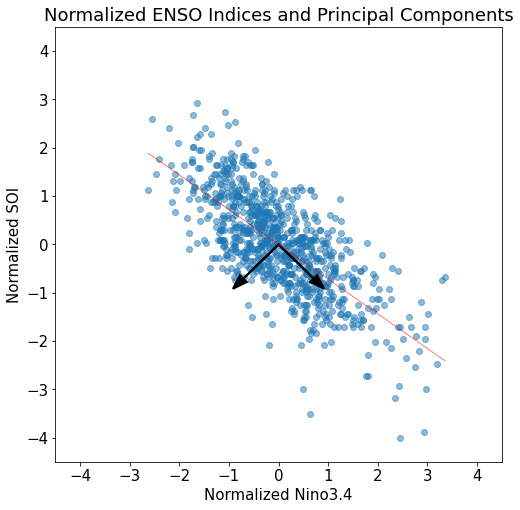

In [45]:
fig=plt.figure(figsize=(8, 8))
plt.rcParams["font.size"] = "15"

pc1 = [pca.components_[1, 1], pca.components_[0, 0]]
pc2 = [pca.components_[1, 0], pca.components_[0, 1]]

plt.scatter(x1, x2, alpha=0.5)
fit = np.poly1d(np.polyfit(x1, x2, 1))
plt.plot(x1, fit(x1), color='red', linewidth=0.5, alpha=0.5)
plt.arrow(x=0, y=0, dx=pc1[1], dy=pc1[0], linewidth=2, head_width=0.2, fc='black')
plt.arrow(x=0, y=0, dx=pc2[1], dy=pc2[0], linewidth=2, head_width=0.2, fc='black')
plt.ylim(-4.5, 4.5)
plt.xlim(-4.5, 4.5)

plt.title('Normalized ENSO Indices and Principal Components')
plt.xlabel('Normalized Nino3.4')
plt.ylabel('Normalized SOI')

plt.show()

Note that the first PC lies nearly (but not quite) along the fit line. The fit line minimizes error in terms of vertical differences to the line whereas the PC minimizes error in terms of the perpendicular differences to the PC, so they are closely related but not identical calculations.

We can display the data rotated/flipped into this new coordinate system, which is also a display of the values of the PCs.

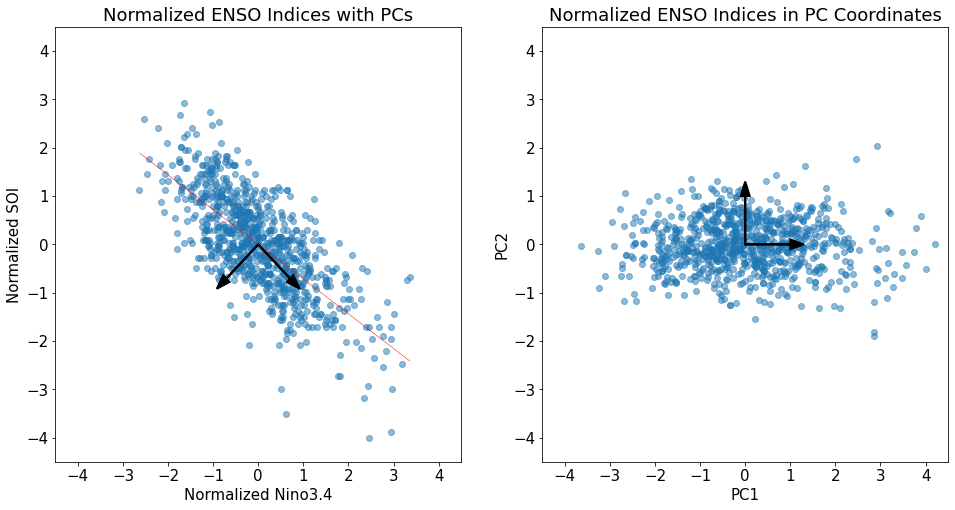

In [46]:
# transform the data into PC coordinates
X_trans = pca.transform(X)
x1_trans = X_trans[:, 0]
x2_trans = X_trans[:, 1]

# which is also the values for the PCs
pc1_values = x1_trans
pc2_values = x2_trans

# now plot
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
plt.rcParams["font.size"] = "15"

pc1 = [pca.components_[1, 1], pca.components_[0, 0]]
pc2 = [pca.components_[1, 0], pca.components_[0, 1]]

axs[0].scatter(x1, x2, alpha=0.5)
fit = np.poly1d(np.polyfit(x1, x2, 1))
axs[0].plot(x1, fit(x1), color='red', linewidth=0.5, alpha=0.5)
axs[0].arrow(x=0, y=0, dx=pc1[1], dy=pc1[0], linewidth=2, head_width=0.2, fc='black')
axs[0].arrow(x=0, y=0, dx=pc2[1], dy=pc2[0], linewidth=2, head_width=0.2, fc='black')
axs[0].set_ylim(-4.5, 4.5)
axs[0].set_xlim(-4.5, 4.5)

axs[0].set_title('Normalized ENSO Indices with PCs')
axs[0].set_xlabel('Normalized Nino3.4')
axs[0].set_ylabel('Normalized SOI')

pc1_trans = [0, 1]
pc2_trans = [1, 0]

axs[1].scatter(x1_trans, x2_trans, alpha=0.5)
axs[1].arrow(x=0, y=0, dx=pc1_trans[1], dy=pc1_trans[0], linewidth=2, head_width=0.2, fc='black')
axs[1].arrow(x=0, y=0, dx=pc2_trans[1], dy=pc2_trans[0], linewidth=2, head_width=0.2, fc='black')
axs[1].set_ylim(-4.5, 4.5)
axs[1].set_xlim(-4.5, 4.5)

axs[1].set_title('Normalized ENSO Indices in PC Coordinates')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')

plt.show()

Note also that we can fully describe every data point either by its Nino3.4 and SOI values or by it's PC1 and PC2 values.

Going back to the earlier plot, we can switch from showing just the unit vector PCs to showing the PCs multipled by their respectve standard deviations, to indicate their relative importance.

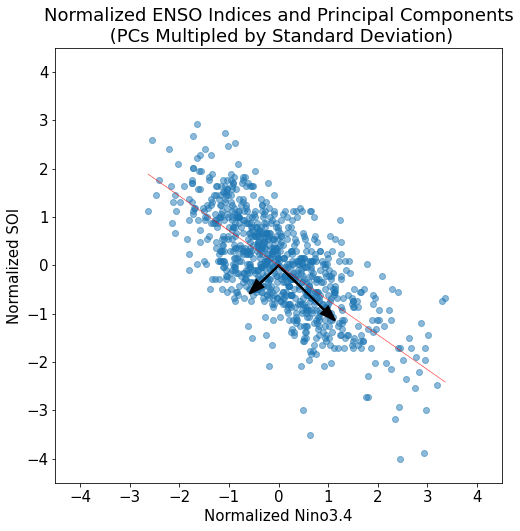

In [47]:
fig=plt.figure(figsize=(8, 8))
plt.rcParams["font.size"] = "15"

pc1_std = np.sqrt(np.mean(pc1_values*pc1_values))
pc2_std = np.sqrt(np.mean(pc2_values*pc2_values))

pc1n = np.array([pca.components_[1, 1], pca.components_[0, 0]])*pc1_std
pc2n = np.array([pca.components_[1, 0], pca.components_[0, 1]])*pc2_std

plt.scatter(x1, x2, alpha=0.5)
fit = np.poly1d(np.polyfit(x1, x2, 1))
plt.plot(x1, fit(x1), color='red', linewidth=0.5, alpha=0.5)
plt.arrow(x=0, y=0, dx=pc1n[1], dy=pc1n[0], linewidth=2, head_width=0.2, fc='black')
plt.arrow(x=0, y=0, dx=pc2n[1], dy=pc2n[0], linewidth=2, head_width=0.2, fc='black')
plt.ylim(-4.5, 4.5)
plt.xlim(-4.5, 4.5)

plt.title('Normalized ENSO Indices and Principal Components\n (PCs Multipled by Standard Deviation)')
plt.xlabel('Normalized Nino3.4')
plt.ylabel('Normalized SOI')

plt.show()

Another perspective is that we can plot the original data in terms of the PC1 and PC2 values (for this data, that's the time series of PC1 and PC2).  Because the PCs are made to be orthogonal, their correlation will be zero. (In this example, there are two variables with values at different times, but in general the values need not be time series.)

In [48]:
print('correlation of PC1 and PC2:',round(pcorr(pc1_values, pc2_values),4))

correlation of PC1 and PC2: 0.0


Let's plot the values of the PCs. Note that PC1 is larger, which is consistent with it explaining more variance.

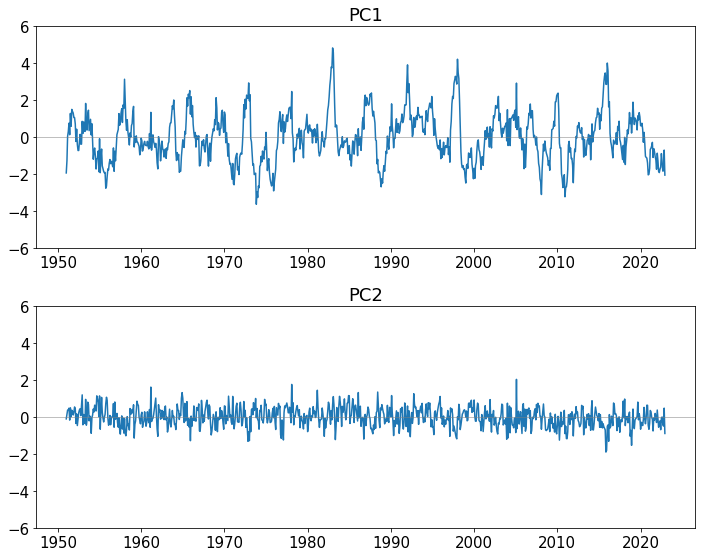

In [49]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
plt.rcParams["font.size"] = "15"


axs[0].plot(times_no_nan, pc1_values)
axs[0].set_title('PC1')


axs[1].plot(times_no_nan, pc2_values)
axs[1].set_title('PC2')

for ax in axs:
    ax.set_ylim(-6, 6)
    ax.axhline(y = 0, linewidth=0.5, color='gray')
    
plt.tight_layout()



Each index can be exactly reconstructed by summing together the contribution that each PC makes to it. 

When a small number of PCs explain a large part of the total variance (here, PC1 explains 86%), we can approximate the data just with those PCs. In this case, we can retain 86% of the information in the data with just one PC instead of the two indices. Perhaps not so impressive to move from two variables to one variable but if we're dealing with tens of thousands of variables and they can be replaced with just a few PCs, that can be very useful.

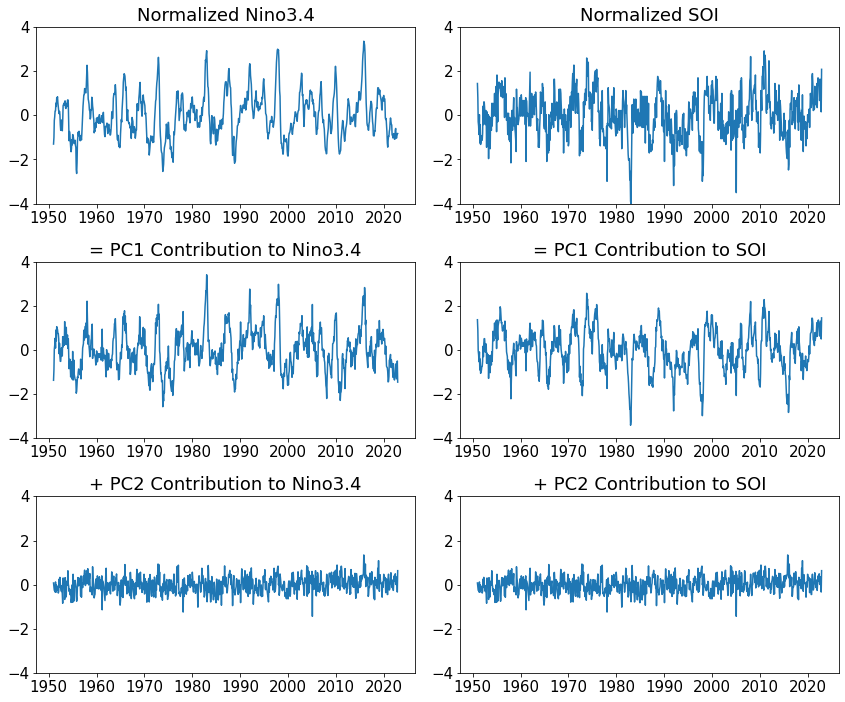

In [50]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# reconstruct the indices based on the PC values and their part of the PC

x1_recon1 = pc1_values*pc1[1]
x1_recon2 = pc2_values*pc2[1]

x2_recon1 = pc1_values*pc1[0]
x2_recon2 = pc2_values*pc2[0]

# there are more consise ways to make a multi-panel plot
# but we're keeping it simple here

axs[0, 0].plot(times_no_nan, x1)
axs[0, 0].set_ylim(-4, 4)
axs[0, 0].set_title('Normalized Nino3.4')

axs[1, 0].plot(times_no_nan, x1_recon1)
axs[1, 0].set_ylim(-4, 4)
axs[1, 0].set_title('= PC1 Contribution to Nino3.4')

axs[2, 0].plot(times_no_nan, x1_recon2)
axs[2, 0].set_ylim(-4, 4)
axs[2, 0].set_title('+ PC2 Contribution to Nino3.4')

axs[0, 1].plot(times_no_nan, x2)
axs[0, 1].set_ylim(-4, 4)
axs[0, 1].set_title('Normalized SOI')

axs[1, 1].plot(times_no_nan, x2_recon1)
axs[1, 1].set_ylim(-4, 4)
axs[1, 1].set_title('= PC1 Contribution to SOI')

axs[2, 1].plot(times_no_nan, x2_recon2)
axs[2, 1].set_ylim(-4, 4)
axs[2, 1].set_title('+ PC2 Contribution to SOI')

plt.tight_layout()


Just to fully convince ourselves, let's plot the normalized Nino3.4 in black and the difference between it and the sum of its two PC contributions in red.

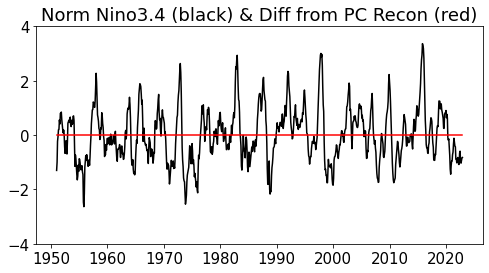

In [51]:
x1_recon = x1_recon1 + x1_recon2

fig=plt.figure(figsize=(8, 4))
plt.plot(times_no_nan, x1, color='black')
plt.plot(times_no_nan, x1 - x1_recon, color='red')
plt.ylim(-4, 4)
plt.title('Norm Nino3.4 (black) & Diff from PC Recon (red)')
plt.show()

And one last perspective on the relationships:  The covariance of the PC values and the indices, divided by the variance of the PC values, yields the PCs.

In [52]:
print('covar(PC1, indices)/var(PC1)', np.mean(pc1_values*x1)/np.mean(pc1_values*pc1_values), 
                                      np.mean(pc1_values*x2)/np.mean(pc1_values*pc1_values))
print('PC1 components:', pc1[1], pc1[0])
print('')
print('covar(PC2, indices)/var(PC2)', np.mean(pc2_values*x1)/np.mean(pc2_values*pc2_values), 
                                      np.mean(pc2_values*x2)/np.mean(pc2_values*pc2_values))
print('PC2 components:', pc1[1], pc1[0])
print('')

covar(PC1, indices)/var(PC1) 0.7071067811865476 -0.7071067811865476
PC1 components: 0.7071067811865475 -0.7071067811865475

covar(PC2, indices)/var(PC2) -0.7071067811865472 -0.7071067811865478
PC2 components: 0.7071067811865475 -0.7071067811865475



**PCA pros and cons, briefly**

PCA pros: uniquely defined; multiple PCs can contribute at the same time; gives info on magnitude; good for linear relationships; data can be exactly reconstructed from PCs

PCA cons: constrained to be orthogonal, which is not necessarily physical (this can be addressed with rotation); poor for non-linear relationships

**Note:** often used to reduce data dimensionality before other techniques, like clustering, are applied.

### 5. K-Means Clustering

Since we already have our data prepared, we can proceed straight to the calculation, and since we're using the sklearn package for both PCA and clustering, the syntax is quite similar.

In [53]:
# Note that for k-means, we have to pick the number of clusters.
# Because our scatter plot looks fairly linear and we only have two variables,
# choosing two clusters is a reasonable choice. There are ways to evaluate the
# choice of cluster number but we don't consider that here.

# It's not necessary, but here we set a specific value for random_state to ensure the same result
# every time the cell is re-run, otherwise the results will change slightly every time 
# the cell is executed

kmeans = sklearn.cluster.KMeans(n_clusters=2, random_state=42)
kmeans.fit(X);

# the semicolon supresses text output that is not useful, but does not affect the calculation

Let's show the cluster centers on the scatter plot.

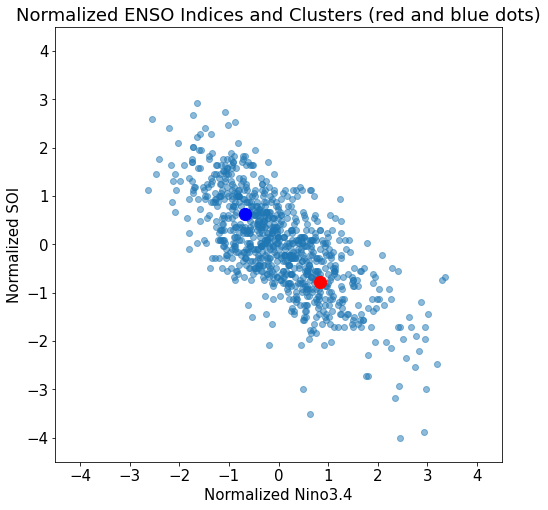

In [54]:
cluster1 = kmeans.cluster_centers_[0, :]
cluster2 = kmeans.cluster_centers_[1, :]

fig=plt.figure(figsize=(8, 8))
plt.rcParams["font.size"] = "15"

plt.scatter(x1, x2, alpha=0.5)

plt.scatter(cluster1[0], cluster1[1], color='blue', s=150)
plt.scatter(cluster2[0], cluster2[1], color='red', s=150)

plt.ylim(-4.5, 4.5)
plt.xlim(-4.5, 4.5)

plt.title('Normalized ENSO Indices and Clusters (red and blue dots)')
plt.xlabel('Normalized Nino3.4')
plt.ylabel('Normalized SOI')

plt.show()

We can also color the points to indicate how they are divided up into the clusters. We used two clusters, so in the plot below blue indicates cluster 1 and red indicates cluster 2. 

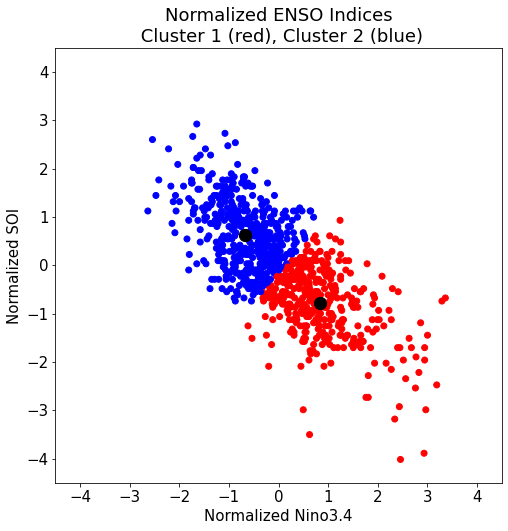

In [55]:
cluster_labels = kmeans.labels_

fig=plt.figure(figsize=(8, 8))
plt.rcParams["font.size"] = "15"

plt.scatter(x1, x2, c=cluster_labels, cmap='bwr')

plt.scatter(cluster1[0], cluster1[1], color='black', s=150)
plt.scatter(cluster2[0], cluster2[1], color='black', s=150)

plt.ylim(-4.5, 4.5)
plt.xlim(-4.5, 4.5)
plt.xlabel('Normalized Nino3.4')
plt.ylabel('Normalized SOI')

plt.title('Normalized ENSO Indices\n Cluster 1 (red), Cluster 2 (blue)')



plt.show()

While each point is assigned to only one cluster, we can add information by changing the color range based on goodness of fit of each point to its cluster. We use the "silhouette" value (s), which includes both the average distance from a point to all other points in its cluster (a) and the average distance to all points in the other cluster (b).  s=(b-a)/max(a,b)

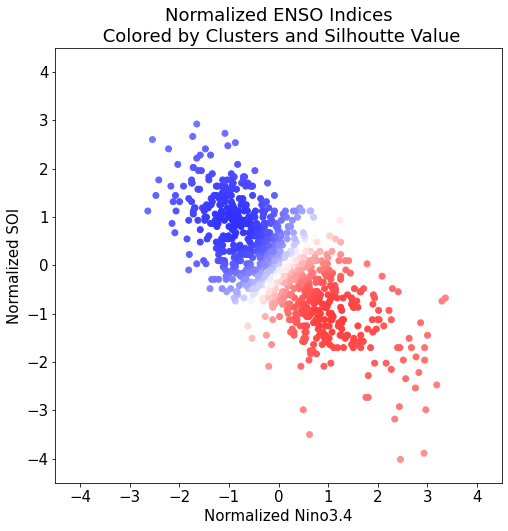

In [56]:
# get silhouette (goodness of fit) values

silhs = sklearn.metrics.silhouette_samples(X, cluster_labels)


# make plot where color range reflects cluster distance

fig=plt.figure(figsize=(8, 8))
plt.rcParams["font.size"] = "15"

dmax = 1*0.8
plt.scatter(x1[cluster_labels==0], x2[cluster_labels==0], c=silhs[cluster_labels==0], 
               cmap='bwr_r', vmin=-dmax, vmax=dmax)
plt.scatter(x1[cluster_labels==1], x2[cluster_labels==1], c=silhs[cluster_labels==1], 
               cmap='bwr', vmin=-dmax, vmax=dmax)

plt.ylim(-4.5, 4.5)
plt.xlim(-4.5, 4.5)
plt.xlabel('Normalized Nino3.4')
plt.ylabel('Normalized SOI')

plt.title('Normalized ENSO Indices\n Colored by Clusters and Silhoutte Value')



plt.show()


We can also plot each index individually, with the values colored by cluster.

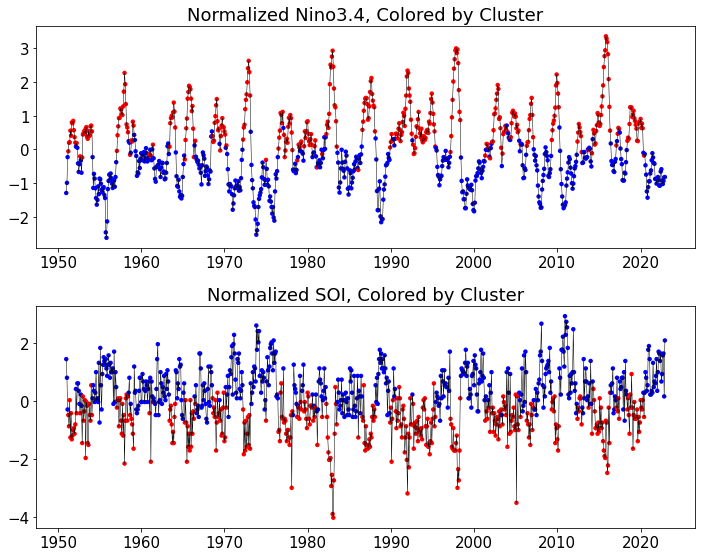

In [57]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
plt.rcParams["font.size"] = "15"

axs[0].plot(times_no_nan, x1, color='black', linewidth=0.5)
axs[0].scatter(times_no_nan, x1, c=cluster_labels, cmap='bwr', s=20, ec=None)
axs[0].set_title('Normalized Nino3.4, Colored by Cluster')

axs[1].plot(times_no_nan, x2, color='black', linewidth=0.5)
axs[1].scatter(times_no_nan, x2, c=cluster_labels, cmap='bwr', s=20, ec=None)
axs[1].set_title('Normalized SOI, Colored by Cluster')

plt.tight_layout()

plt.show()

Finally, note that averaging together all the values identified in a cluster yields the cluster center. That is, the cluster center is the average of all its members.

In [58]:
print('average of all cluster 1:', np.mean(x1[cluster_labels==0]), np.mean(x2[cluster_labels==0]))
print('cluster 1 components:', cluster1[0], cluster1[1])
print('')
print('average of all cluster 2:', np.mean(x1[cluster_labels==1]), np.mean(x2[cluster_labels==1]))
print('cluster 2 components:', cluster2[0], cluster2[1])

average of all cluster 1: -0.6829805561756062 0.6346655407840213
cluster 1 components: -0.6829805561756063 0.634665540784021

average of all cluster 2: 0.8457634866630563 -0.7859329753750314
cluster 2 components: 0.8457634866630566 -0.7859329753750315


**Clustering Pros and Cons, briefly**

Pros: can handle non-linear data
<br>Cons: every value is assigned to only one cluster, so can't account for multiple simutaneous influences; not uniquely defined; have to pick number of clusters

### 6. Comparing PCA and Clustering

Let's put the plots side by side to compare the results of the two different approaches.

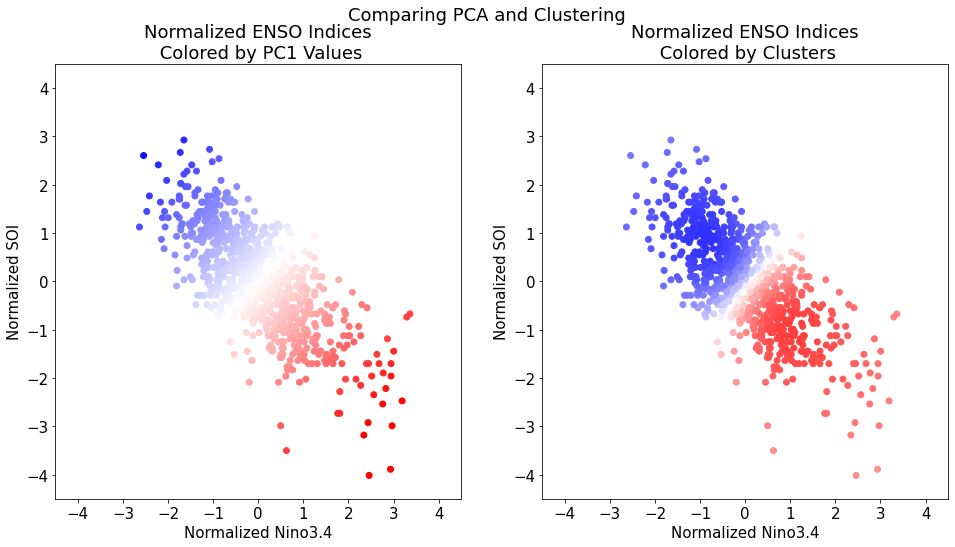

In [59]:
# plot comparing PCA and Clustering

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

fig.suptitle('Comparing PCA and Clustering')

plt.rcParams["font.size"] = "15"

dmax = np.amax(np.abs(pc1_values))*0.8
axs[0].scatter(x1, x2, c=pc1_values, cmap='bwr', vmin=-dmax, vmax=dmax)
axs[0].set_title('Normalized ENSO Indices\n Colored by PC1 Values')

dmax = 1*0.8
axs[1].scatter(x1[cluster_labels==0], x2[cluster_labels==0], c=silhs[cluster_labels==0], 
               cmap='bwr_r', vmin=-dmax, vmax=dmax)
axs[1].scatter(x1[cluster_labels==1], x2[cluster_labels==1], c=silhs[cluster_labels==1], 
               cmap='bwr', vmin=-dmax, vmax=dmax)

axs[1].set_title('Normalized ENSO Indices\n Colored by Clusters')

for ax in axs:
    ax.set_ylim(-4.5, 4.5)
    ax.set_xlim(-4.5, 4.5)
    ax.set_xlabel('Normalized Nino3.4')
    ax.set_ylabel('Normalized SOI')

plt.show()

As we would hope for in this simple case, the results are very similar in terms of separating the data into two groups. (Physically, in this case, El Nino in red and La Nina in blue.) There is some difference in the intensity of the colors, as displayed here. The PCs, as vectors, have largest vaues (darkest colors) at the extremes. The clusters, as central locations, have the best fits (darkest colors) at their centers. Neither of these perspectives is necessarily better, just somewhat different.

We can also put the PC vectors (multiplied by standard deviation) and cluster centers together. Keeping in mind that the PCs can be positive or negative, we've added gray vectors to highlight that.

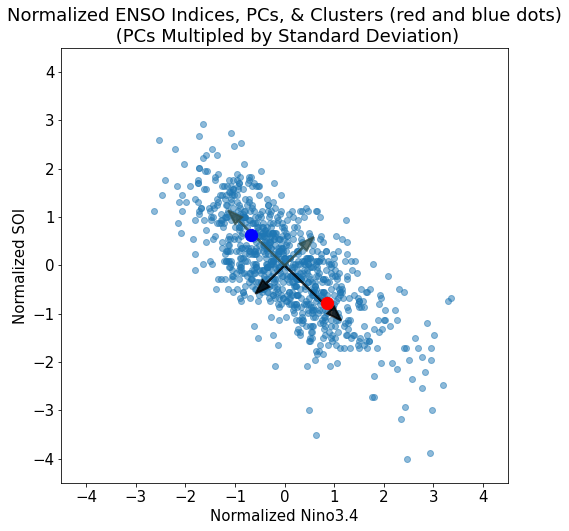

In [60]:
fig=plt.figure(figsize=(8, 8))
plt.rcParams["font.size"] = "15"

pc1_std = np.sqrt(np.mean(pc1_values*pc1_values))
pc2_std = np.sqrt(np.mean(pc2_values*pc2_values))

pc1n = np.array([pca.components_[1, 1], pca.components_[0, 0]])*pc1_std
pc2n = np.array([pca.components_[1, 0], pca.components_[0, 1]])*pc2_std

plt.scatter(x1, x2, alpha=0.5)

plt.arrow(x=0, y=0, dx=pc1n[1], dy=pc1n[0], linewidth=2, head_width=0.2, fc='black', alpha=0.8)
plt.arrow(x=0, y=0, dx=pc2n[1], dy=pc2n[0], linewidth=2, head_width=0.2, fc='black', alpha=0.8)

plt.arrow(x=0, y=0, dx=-pc1n[1], dy=-pc1n[0], linewidth=2, head_width=0.2, color='darkslategray', alpha=0.8)
plt.arrow(x=0, y=0, dx=-pc2n[1], dy=-pc2n[0], linewidth=2, head_width=0.2, color='darkslategray', alpha=0.8)

plt.scatter(cluster1[0], cluster1[1], color='blue', s=150)
plt.scatter(cluster2[0], cluster2[1], color='red', s=150)

plt.ylim(-4.5, 4.5)
plt.xlim(-4.5, 4.5)

plt.title('Normalized ENSO Indices, PCs, & Clusters (red and blue dots)\n (PCs Multipled by Standard Deviation)')
plt.xlabel('Normalized Nino3.4')
plt.ylabel('Normalized SOI')

plt.show()


This perspective also shows the close correspondence between PC1 and the two clusters. Note that the PC vectors must be symmetric about the origin but the clusters need not be. Physically, the clusters are capturing that El Nino events tend to be stronger than La Nina events. That information is present in the PC1 values but not directly in the PC1 vector.

### 6. Next Steps

This introduction covers some of the most basic ideas of PCA and clustering, but does not consider most of the complexities that are typically encountered when actually using these techniques.

Some key aspects that are not considered here:  rotation of PCs, how to choose the number of clusters (or PCs to rotate), different types of clustering, area-weighting for lat-lon data, and working with data that is 2D or 3D in terms of spatial dimensions. Some of these are straightforward to deal with (e.g., area-weighting), others can be more subtle (e.g., choosing the number of clusters).

### 7. Examples of PCA and clustering in the wild

*Rotated PCA of sea surface temperatures*

Barlow, M., S. Nigam, and E. H. Berbery, 2001: ENSO, Pacific decadal variability, and U.S. 
summertime precipitation, drought, and streamflow.  J. Climate, 14, 2105-2128.__[https://doi.org/10.1175/1520-0442(2001)014<2105:EPDVAU>2.0.CO;2](https://doi.org/10.1175/1520-0442(2001)014<2105:EPDVAU>2.0.CO;2)__

*Cluster analysis of circulation fields during extreme precipitation events*

Agel, L., Barlow, M., Feldstein, S. B., & Gutowski, W. J., 2018: Identification of large-scale meteorological patterns associated with extreme precipitation in the US Northeast. Clim. Dyn., 50 (5-6), 1819-1839. https://doi.org/10.1007/s00382-017-3724-8



